In [1]:
import rlibpy
from rlibpy.agent import AdaptiveQLearningAgent
from rlibpy.policy import EpsilonGreedy
from rlibpy.policy.epsilon_greedy import get_decay_rate

import radargym
import gym
import numpy as np
import matplotlib.pyplot as plt

from trackingsimpy.trajectories import load_trajectory, get_file_list

from IPython.display import HTML

# %load_ext autoreload
# %autoreload 2
%matplotlib inline

# Simulation description

**Symbols**

* $P$ --- Peak transmit power in watts
* $G$ --- Antenna gain (linear)
* $\lambda$ --- Operating frequency wavelength in meters
* $\sigma$ --- Target RCS
* $R$ --- Target distance
* $P_\text{N}$ ---  Thermal noise power
* $B$ --- Half of the -3dB beamwidth in radians i.e. $\frac{B_{-3dB}}{2}$
* $\theta$ --- Target azimuth angle in radians
* $\hat{\theta}$ --- Estimated target azimuth angle in radians
* $P_\text{d}$ --- Probability of detection
* $P_\text{fa}$ --- Probability of false alarm
* $N$ --- Number of pulses integrated


## Target model

A benchmark target trajectory shown [here](https://www.mathworks.com/help/fusion/examples/benchmark-trajectories-for-multi-object-tracking.html) are used in the simulations.
For the sake of simplicity, the dimension is downsized from 3D to 2D and only the trajectory number 5 is used.

All the 2D trajectories are shown in the figure below.


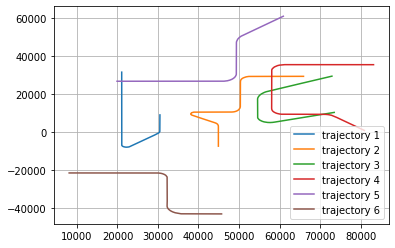

In [2]:
plt.figure()
for idx,filename in enumerate(get_file_list()):
    traj = load_trajectory(filename, 0,2)
    plt.plot(traj[:, 0], traj[:, 1], label='trajectory ' + str(idx+1))
    plt.grid(True)
    plt.legend()

## Measurement model

The measurement model is based on the following equation

\begin{equation}
    \mathbf{z} = \mathbf{H} \mathbf{x} + \mathbf{v},
\end{equation}

where $\mathbf{H}$ is defined as follows

\begin{equation}
    \mathbf{H} = \left( \begin{matrix} 1 & 0 & 0 & 0 \\ 0 & 0 & 1 & 0 \end{matrix} \right)
\end{equation}

and $\mathbf{v} \in \mathcal{N}(0, \mathbf{R})$. 


The measurement covariance matrix $\mathbf{R}$ is approximated by utilizing measurement error variances in polar coordinate system as follows

\begin{equation}
    \mathbf{R} = \mathbf{T} \mathbf{R}_{\text{p}}  \mathbf{T}^\text{T}
\end{equation}

where $\mathbf{R}_\text{p}$ is measurement covariance matrix in 2D polar coordinates and $\mathbf{T}$ is rotation matrix is 2D coordinates.

\begin{equation}
    \mathbf{R}_\text{p} = \left( \begin{matrix} \sigma_r^2 & 0 \\ 0 & \sigma_\theta^2  \end{matrix} \right)
\end{equation}

\begin{equation}
    \mathbf{T} = \left(
        \begin{array}{cc}
            \cos(\theta) & -\sin(\theta) \\
            \sin(\theta) & \cos(\theta)
        \end{array}
    \right)
\end{equation}

The measurement noise variance in radial coordinate $\sigma_r^2$ and azimuth coordinate $\sigma_\theta^2$ are calculated from the following equations

\begin{align}
    \sigma_r^2 =  r_\text{res}\left(a_r SNR^{-\frac{1}{2}} + b_r \right)  \label{eq:sigma_r}\\
    \sigma_\theta^2 =  \theta_\text{res}\left(a_\theta SNR^{-\frac{1}{2}} + b_\theta \right)\label{eq:sigma_theta}
\end{align}

where $r_\text{res}$ is range resoultion and $\theta_\text{res}$ is azimuth resolution. The parameters $a_r$, $a_\theta$, $b_r$ and $b_\theta$ are radar spesific constants.



The probability of detection is accounted in the simulations such that all dwells might not lead into detection.
A Singer model I for target RCS is used for which the probability of detection is

\begin{equation}
    P_\text{d} = P_\text{fa}^{\frac{1}{1+SNR}}.
\end{equation}

The central beam SNR $SN_0$ is assumed constant in the simulations. However, the beam offset is accounted by using following equation

\begin{equation} \label{eq:snr}
    SNR = SN_0 \exp{ \left( - \ln{2}
        \frac
            {(\hat{\theta} - \theta)^2}
            {B^2}
    \right)}    
\end{equation}
which models mainlobe of the radar beam.

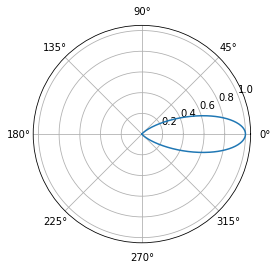

In [3]:
plt.figure()
theta = np.linspace(-np.pi, np.pi, 1000)
bw = 20/180*np.pi
plt.polar(theta, np.exp(-np.log(2)*theta**2/(bw**2)))
plt.show()

## Tracker

Kalman filter is used to track the target. Since only single target tracking scenario is simulated, the track association is not considered.
The model used in the Kalman filter is constant velocity (CV) model, which is defined as follows:

\begin{equation}
\hat{\mathbf{x}} = \begin{pmatrix}
x\\ 
\dot{x}\\ 
y\\ 
\dot{y}
\end{pmatrix}
\end{equation}

\begin{equation}
F=
\begin{pmatrix}
1 & \Delta t & 0 & 0 \\ 
0 & 1 & 0 & 0 \\ 
0 & 0 & 1 & \Delta t \\ 
0 & 0 & 0 & \Delta t
\end{pmatrix}
\end{equation}

\begin{equation}
Q = \begin{pmatrix}
\frac{1}{4} \Delta t^4 & \frac{1}{2} \Delta t^3 & 0 & 0 \\ 
\frac{1}{2} \Delta t^3 & \Delta t^2 & 0 & 0 \\ 
0 & 0 & \frac{1}{4} \Delta t^4 & \frac{1}{2} \Delta t^3\\ 
0 & 0 & \frac{1}{2} \Delta t^3 & \Delta t^2
\end{pmatrix}
\end{equation}

The noise covariance matrix is derived from the assumption that Gaussian accelerations along each dimension are decoupled. 

# Reinforcement learning formulation

## Rewards

\begin{equation}
    R = 
    \left\{
        \begin{array}{ll}
            -c_{\text{loss}}, & \text{if track lost} \\
            -\frac{1}{t_\text{r}}, & \text{otherwise.}
        \end{array}
    \right.
\end{equation}

The track lost cost defined with parameter $c_{\text{loss}}$ is used to tell the agent how important the tracking task is related to the time the track will take. Especially, the cost needs to be related to the time horizon the agent is considering. In reinforcement learning the considered time horizon is defined with discount factor $\lambda$. If the immediate rewards are constant, then the discounted sum is $\frac{1}{1-\lambda}$ times the immediate reward. This can be used to determine suitable cost for the lost track.

For example, the event of losing track could be as bad as tracking target with lowest revisit interval (meaning highest tracking load) for the whole time horizon. Therefore, the cost for track lost would be $c_{\text{loss}}=\frac{1}{1-\lambda}$.

## Actions

Actions discretized linearly such that the action space is 
\begin{equation}\label{eq:as_direct}
    \mathcal{A} := \left\{ \frac{n T_\text{max} + (N-n-1) T_\text{min}}{N-1} \right\}_{n=0}^{N-1}  
\end{equation}

The actions are shown in the figure below.

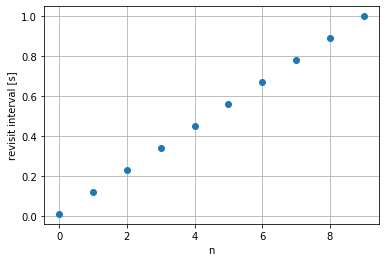

In [4]:
n = np.arange(10)

plt.figure()
plt.plot(n, (n*1 + (10 - n -1) * 0.01) / (10-1), 'o')
plt.grid(True)
plt.xlabel('n')
plt.ylabel('revisit interval [s]')
plt.show()

## States

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  overflow:hidden;padding:10px 5px;word-break:normal;}
.tg th{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  font-weight:normal;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg .tg-fymr{border-color:inherit;font-weight:bold;text-align:left;vertical-align:top}
.tg .tg-0pky{border-color:inherit;text-align:left;vertical-align:top}
</style>
<table class="tg">
  <tr>
    <th class="tg-fymr">m</th>
    <th class="tg-fymr">Range of angle errors</th>
    <th class="tg-fymr">Description</th>
  </tr>
  <tr>
    <td class="tg-0pky">0</td>
    <td class="tg-0pky">&lt; $g_\text{low} B$</td>
    <td class="tg-0pky">Below defined threshold</td>
  </tr>
  <tr>
    <td class="tg-0pky">1-7</td>
    <td class="tg-0pky"> $< \frac{g_\text{high} - g_\text{low}}{M - 3} m + g_\text{low}$ </td>
    <td class="tg-0pky">Linearly discretized between $g_\text{low} B$ and $g_\text{high} B$</td>
  </tr>
  <tr>
    <td class="tg-0pky">8</td>
    <td class="tg-0pky">&gt; $g_\text{high} B$</td>
    <td class="tg-0pky">Above defined threshold</td>
  </tr>
  <tr>
    <td class="tg-0pky">9</td>
    <td class="tg-0pky">-</td>
    <td class="tg-0pky">Target lost</td>
  </tr>
</table>

## Q-learning algorithm

Q-learning algorithm utilizes temporal difference update rule to update action-values for each state-action pair:

\begin{equation}
    Q(s, a) \leftarrow Q(s, a) + \alpha \left( r + \lambda \max_a Q(s', a) - Q(s, a) \right)
\end{equation}

The small value for parameter $\alpha$ is used to approximate mean value by Monte Carlo simulations. In addition, $\alpha$ can be adaptive to allow faster converge and higher precision when the agent is trained for a long time. For example, in myopic case $\alpha = 1/k$, where $k$ is the number of action $a$ taken from state $s$ is calculates the empirical mean of immediate rewards. In non-myopic case $\alpha=1/k^\omega$ where $0 < \omega < 1$ could be used which was shown in [here](http://www.jmlr.org/papers/volume5/evendar03a/evendar03a.pdf).

To prevent converge to local optimal, Q-learning algorithm needs to use policy that addresses the exploration and exploitation tradeoff.
Typical choice is to use $\epsilon$-greedy policy where random action is taken with probability $\epsilon$.
It is usually necessary to decrease the parameter $\epsilon$ since otherwise the agent may not explore the whole state space efficiently. For example, in tracking applications random actions can lead to lost target.

# Simulations

The simulations are based on the assumptions presented in the last sections. Four different cases are considered to illustrate the difference between non-myopic and myopic policies. In addition, the simulations show the effect on defining the track lost cost parameter.

In [2]:
def get_penalty(cost, gamma):
    return cost / (1-gamma)

def visualize_policy_table(agent):
    _obs = np.arange(agent.environment.N_OBS) - 0.5
    _acts = np.arange(agent.environment.N_ACTS+1) - 0.5
    plt.figure()
    plt.pcolor(_acts, _obs, np.log10(np.abs(agent.table[:-1, :])), edgecolors='k')
    plt.plot(agent.table[:-1, :].argmax(axis=1), np.arange(0, env.N_OBS-1), 'r-o')
    plt.ylabel('Observation')
    plt.xlabel('Action')
    cbar = plt.colorbar()
    cbar.set_label('Penalty [dB]')
    plt.show()
    
def visualize_covergence_analytics(agent):
    plt.figure()
    j = 7
    for i in range(10):
        plt.plot(np.log(np.abs(agent.q_hd[j, i])+1), label=str(i))
    plt.legend()
    plt.grid(True)
    plt.title('Penalty')
    plt.xscale('log')
    plt.show()
    
def evaluate(agent, max_steps):
    env = agent.environment
    sim = env.sim
    sim.enable_saving()
    obs = env.reset()
    for i in range(max_steps):
        act = agent.act(obs, evaluate=True)
        obs, reward, done, _ = env.step(act)
        if done:
            break
    
    sim.saver.convert_to_numpy()
    sim.disable_saving()
    
n_ep = 100
eps_s = 0.2
eps_e = 1e-3
decay = get_decay_rate(eps_s, eps_e, n_ep)
omega_myopic = 1
omega_non_myopic = 0.5
gamma_myopic = 0.0
gamma_non_myopic = 0.98
cost_low = 10
cost_high = 1000
n_log = 25
max_steps = 10_000

env = gym.make("revisit-v0")
policy = EpsilonGreedy(eps_s, decay)
agent = AdaptiveQLearningAgent(env, policy, omega=None, gamma=None, debug=True)

## Case 1: Myopic objective with low penalty

In [3]:
env.P_LOSS = get_penalty(cost_low, gamma_myopic)
agent.gamma = gamma_myopic
agent.omega = omega_myopic

In [4]:
agent.reset()
agent.learn(n_ep, max_steps=max_steps, n_log=n_log)

episode 1, Avg reward -0.84, Avg steps 3.4
episode 26, Avg reward -12.97, Avg steps 64.16
episode 51, Avg reward -21.01, Avg steps 203.16
episode 76, Avg reward -21.48, Avg steps 353.12


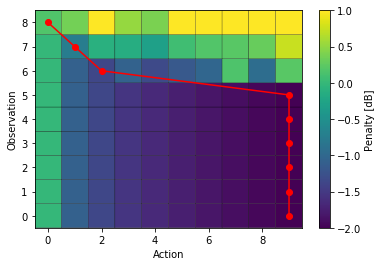

In [5]:
visualize_policy_table(agent)

In [6]:
evaluate(agent, max_steps)
anim = env.sim.get_animation()
plt.close()
HTML(anim.to_html5_video())

## Case 2: Myopic objective with high penalty

In [7]:
env.P_LOSS = get_penalty(cost_high, gamma_myopic)

In [8]:
agent.reset()
agent.learn(n_ep, max_steps, n_log=n_log)

episode 1, Avg reward -40.44, Avg steps 3.44
episode 26, Avg reward -1001.27, Avg steps 52.16
episode 51, Avg reward -1004.93, Avg steps 130.24
episode 76, Avg reward -1011.10, Avg steps 402.76


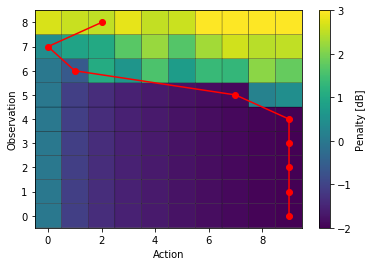

In [9]:
visualize_policy_table(agent)

In [10]:
evaluate(agent, max_steps)
anim = env.sim.get_animation()
plt.close()
HTML(anim.to_html5_video())

## Case 3: Non-myopic objective with low penalty

In [11]:
env.P_LOSS = get_penalty(cost_low, gamma_non_myopic)
agent.gamma = gamma_non_myopic
agent.omega = omega_non_myopic

In [12]:
agent.reset()
agent.learn(n_ep, max_steps, n_log=n_log)

episode 1, Avg reward -20.57, Avg steps 3.92
episode 26, Avg reward -512.92, Avg steps 111.72
episode 51, Avg reward -554.66, Avg steps 408.0
episode 76, Avg reward -597.14, Avg steps 980.84


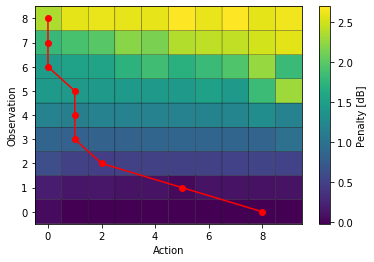

In [13]:
visualize_policy_table(agent)

In [14]:
evaluate(agent, max_steps)
anim = env.sim.get_animation()
plt.close()
HTML(anim.to_html5_video())

## Case 4: Non-myopic objective with high penalty

In [15]:
env.P_LOSS = get_penalty(cost_high, gamma_non_myopic)

In [16]:
agent.reset()
agent.learn(n_ep, max_steps, n_log=n_log)

episode 1, Avg reward -2000.48, Avg steps 3.68
episode 26, Avg reward -50011.52, Avg steps 109.08
episode 51, Avg reward -50070.41, Avg steps 373.48
episode 76, Avg reward -14442.25, Avg steps 1213.48


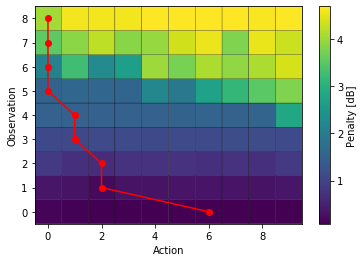

In [17]:
visualize_policy_table(agent)

In [18]:
evaluate(agent, max_steps)
anim = env.sim.get_animation()
plt.close()
HTML(anim.to_html5_video())